<a href="https://colab.research.google.com/github/Svetorus/Data-Science/blob/main/DZ_Catboost_roc_auc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Функции

Смотрим корреляцию

In [ ]:
import textwrap

def scatter_matrix(df):
    axs = pd.plotting.scatter_matrix(df, figsize=[20,20])

    def wrap(txt, width=8):
        '''helper function to wrap text for long labels'''
        return '\n'.join(textwrap.wrap(txt, width))

    for ax in axs[:,0]: # the left boundary
        ax.grid('off', axis='both')
        ax.set_ylabel(wrap(ax.get_ylabel()), rotation=0, va='center', ha='right', labelpad=20)
        ax.set_yticks([])

    for ax in axs[-1,:]: # the lower boundary
        ax.grid('off', axis='both')
        ax.set_xlabel(wrap(ax.get_xlabel()), rotation=90)
        ax.set_xticks([])

    return plt.show()

In [ ]:
def get_boxplot(X, columns=[]):
    for i in columns:
        sns.boxplot(x=X[i])
    pass

def get_pairplot(X, columns=None):
    if columns is None:
        columns = list(X.columns)
    sns.pairplot(X[columns])
    pass    

Определяем результат фичей в паре, которые сильнее влияют на целевую переменную, с помощью CatBoostRegressor.

In [ ]:
def main_features(df):
    cat_features = [i for i, (col, ser) in enumerate(df.iteritems()) if ser.dtype == object]
    pool = Pool(data=df.iloc[:, :-1], label=df.iloc[:, -1], cat_features=cat_features)

    model = CatBoostRegressor(iterations=100, 
                              depth=2,silent=True, 
                              loss_function='RMSE')

    model.fit(pool)

    preds = model.get_feature_importance(data=pool, type='Interaction')
    
    data_new_fichy = pd.DataFrame({'first_feature':[i[0] for i in preds],
                  'second_feature':[i[1] for i in preds],
                  'impact on Y in %':[i[2] for i in preds]})
    number_fich = dict(enumerate(df.iloc[0:0,1:].columns, start=1))
    for i in data_new_fichy['first_feature']:
        if i in number_fich:
            data_new_fichy.loc[data_new_fichy['first_feature']==i,'first_feature']=number_fich[i]
    for i in data_new_fichy['second_feature']:
        if i in number_fich:
            data_new_fichy.loc[data_new_fichy['second_feature']==i,'second_feature']=number_fich[i]      
    data_new_fichy['impact on Y in %'] = round(data_new_fichy['impact on Y in %'],2)
    return data_new_fichy

Важность признаков

In [ ]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

Выбор порога вероятности для определения класса

In [ ]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

Вывод метрик

In [ ]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

# Подключение библиотек и скриптов

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.2 MB/s 


In [ ]:
import pandas as pd # Для работы с данными
import numpy as np
import itertools
import random
from google.colab import files # Библиотека для загрузки файлов

import scipy.stats # При работе со статистикой
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from catboost import Pool, CatBoostRegressor
from sklearn.svm import SVC
 
import seaborn as sns # Библиотека для визуализации результатов
from matplotlib import pyplot as plt # Библиотека для визуализации результатов
from pylab import rcParams
%matplotlib inline

загружаем фаил в colab

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving athletes.csv to athletes.csv


читаем фаил

In [ ]:
data = pd.read_csv('athletes.csv')

получить небольшой случайный набор строк

In [ ]:
data.sample(frac=0.05).head()

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
10199,82177310,Svetlana Radzivil,UZB,female,1/17/87,1.86,61.0,athletics,0,0,0
11158,260382082,Yannick Agnel,FRA,male,6/9/92,2.01,80.0,aquatics,0,0,0
2765,965509678,Dylan Kennett,NZL,male,12/8/94,1.78,75.0,cycling,0,0,0
11134,308918609,Yanan Sun,CHN,female,9/15/92,1.61,51.0,wrestling,0,0,1
5038,444015390,John Nunn,USA,male,2/3/78,1.88,78.0,athletics,0,0,0


Обзор данных

In [ ]:
data.iloc[0]

id                  736041664
name           A Jesus Garcia
nationality               ESP
sex                      male
dob                  10/17/69
height                   1.72
weight                   64.0
sport               athletics
gold                        0
silver                      0
bronze                      0
Name: 0, dtype: object

Выводим количество строк и колонок

In [ ]:
data.shape

(11538, 11)

Смотрим данные по файлу

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11208 non-null  float64
 6   weight       10879 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


Количество пропущенных значений (в процентах)

In [ ]:
round((len(data) - data.count()) / len(data) * 100, 2).sort_values(ascending=False).head()

weight    5.71
height    2.86
dob       0.01
id        0.00
name      0.00
dtype: float64

подсчитать количество значений

In [ ]:
data.sex.value_counts()

male      6333
female    5205
Name: sex, dtype: int64

Количество уникальных значений по каждому из признаков

In [ ]:
data.nunique().sort_values()

sex                2
silver             3
bronze             3
gold               6
sport             28
height            82
weight           123
nationality      207
dob             5595
name           11517
id             11538
dtype: int64

Смотрим типы

In [ ]:
data.dtypes

id               int64
name            object
nationality     object
sex             object
dob             object
height         float64
weight         float64
sport           object
gold             int64
silver           int64
bronze           int64
dtype: object

## Формирование списков признаков

In [ ]:
TARGET_NAME = 'sex'
NUM_FEATURE_NAMES = data.select_dtypes(include=np.number).columns.tolist()
CAT_FEATURE_NAMES = data.select_dtypes(include='object').columns.tolist()

In [ ]:
data[TARGET_NAME].value_counts()

male      6333
female    5205
Name: sex, dtype: int64

Количественные признаки в разрезе целевой переменной

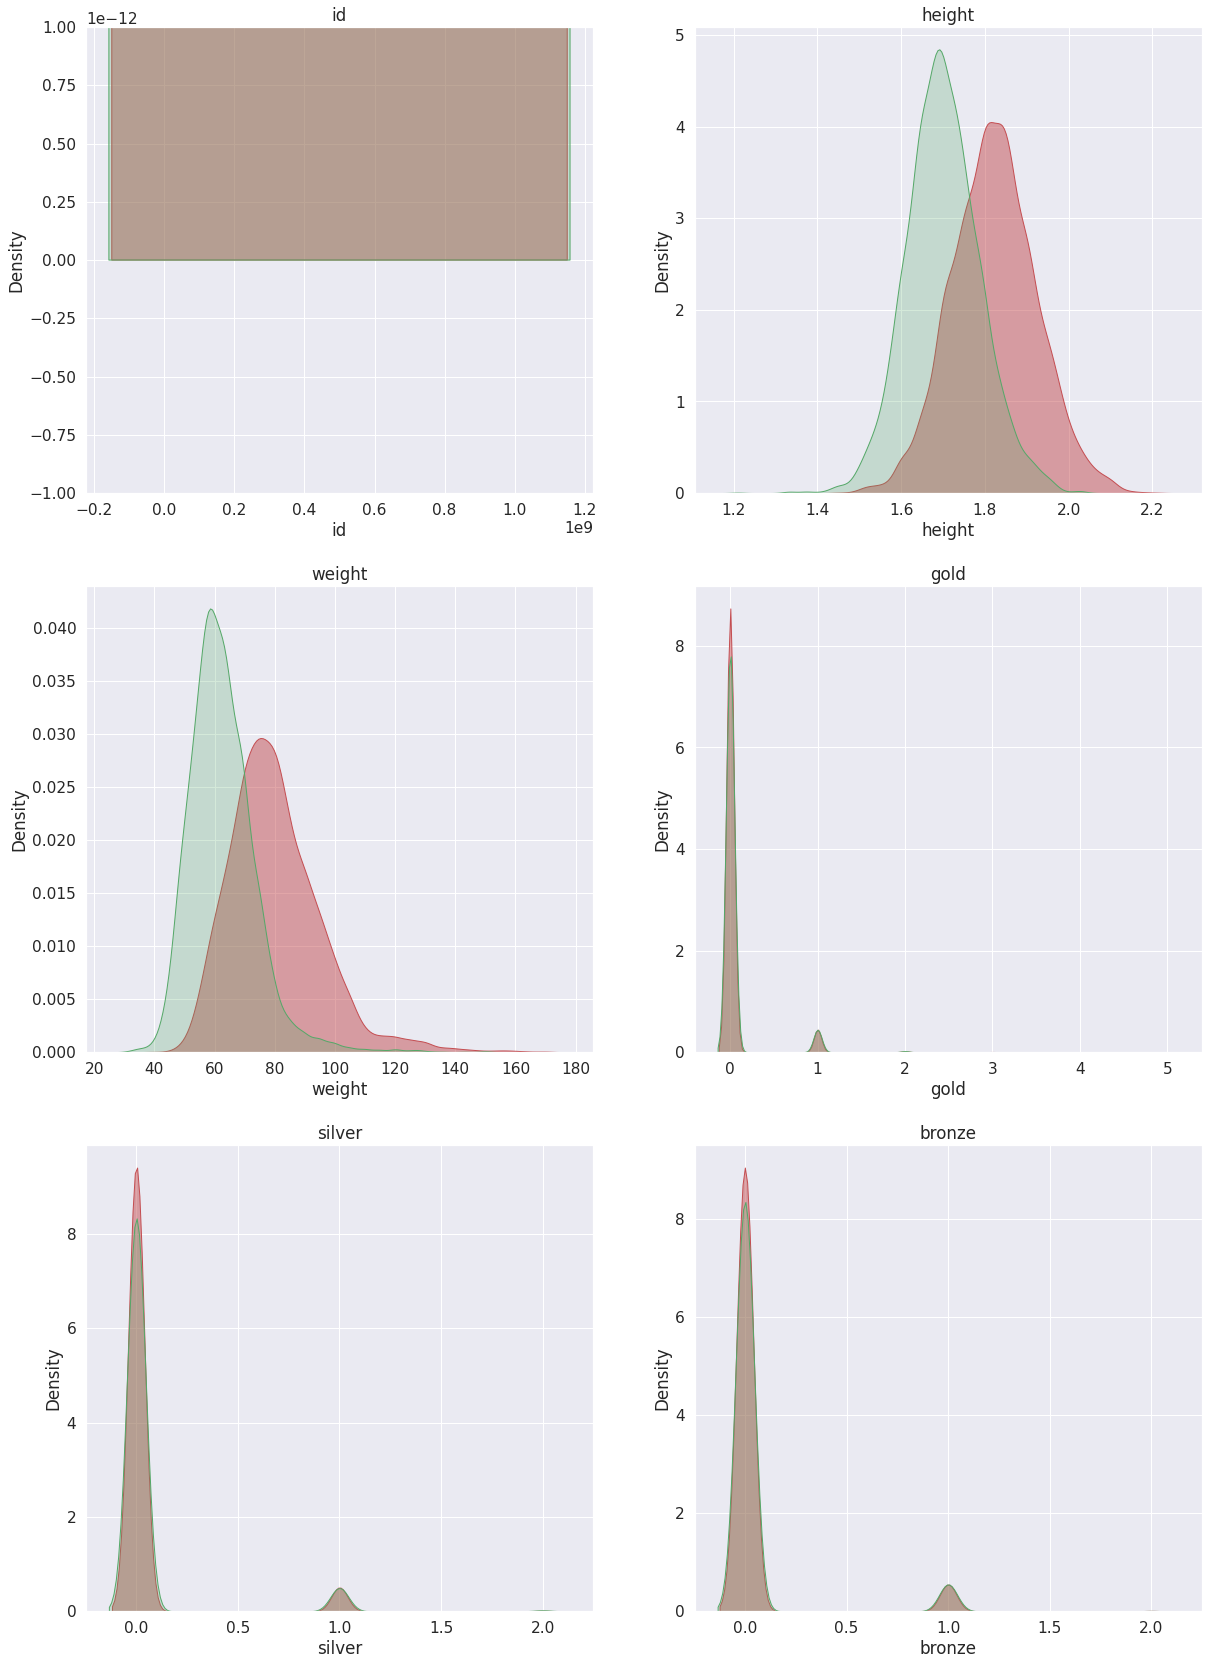

In [ ]:
sns.set(font_scale=1.4)
plt.figure(figsize=(20,60))

for i, colname in enumerate(NUM_FEATURE_NAMES):
    plt.subplot(6,2,i+1)
    plt.title(colname)
    sns.kdeplot(data.loc[data[TARGET_NAME] == 'male', colname], shade=True, alpha=0.5, legend=False, color='r')
    sns.kdeplot(data.loc[data[TARGET_NAME] == 'female', colname], shade=True, legend=False, color='g')
    
plt.show()

Категориальные признаки в разрезе целевой переменной  
т.к. в столбцах много значений, вывод их приводит к беспорядку на графике

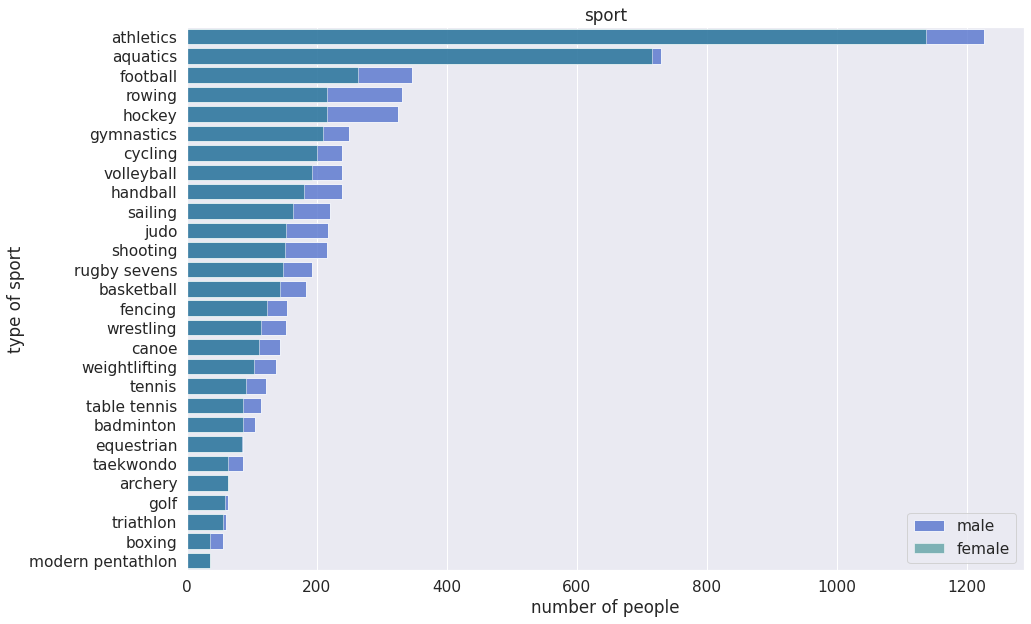

In [ ]:
import warnings
warnings.simplefilter('ignore')

colname = 'sport'

sns.set(font_scale=1.4)
plt.figure(figsize=(15,10))

plt.title(colname)
    
val_counts_t1 = data.loc[data[TARGET_NAME] == 'male', colname].value_counts()
val_counts_t0 = data.loc[data[TARGET_NAME] == 'female', colname].value_counts()
    
sns.barplot(val_counts_t1.values, val_counts_t1.index, alpha=0.8, label='male', color='royalblue',)
sns.barplot(val_counts_t0.values, val_counts_t0.index, alpha=0.5, label='female', color='darkcyan')
plt.legend(loc="lower right")
plt.ylabel("type of sport")
plt.xlabel("number of people")
    
plt.show()

Оценка корреляций с целевой переменной

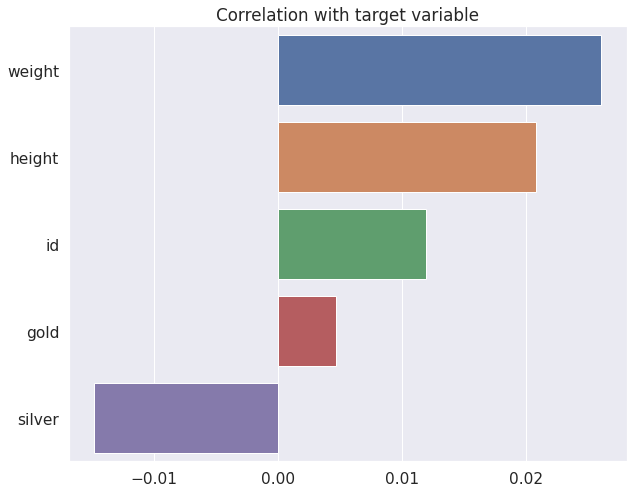

In [ ]:
corr_with_target = data.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Анализ линейных зависимостей в признаковом пространстве

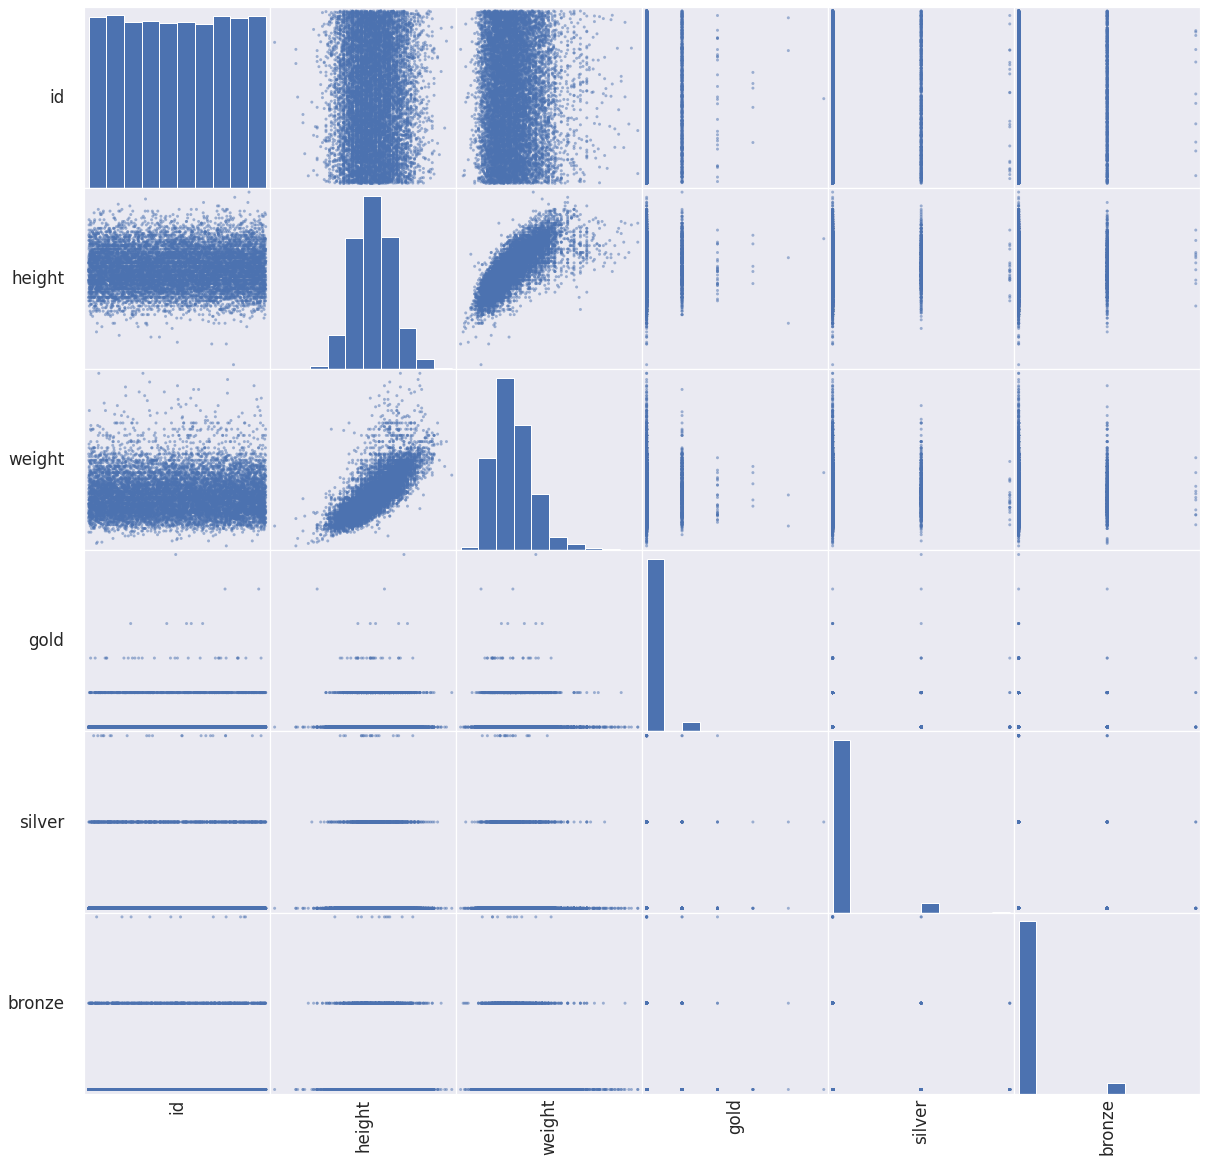

In [ ]:
scatter_matrix(data)

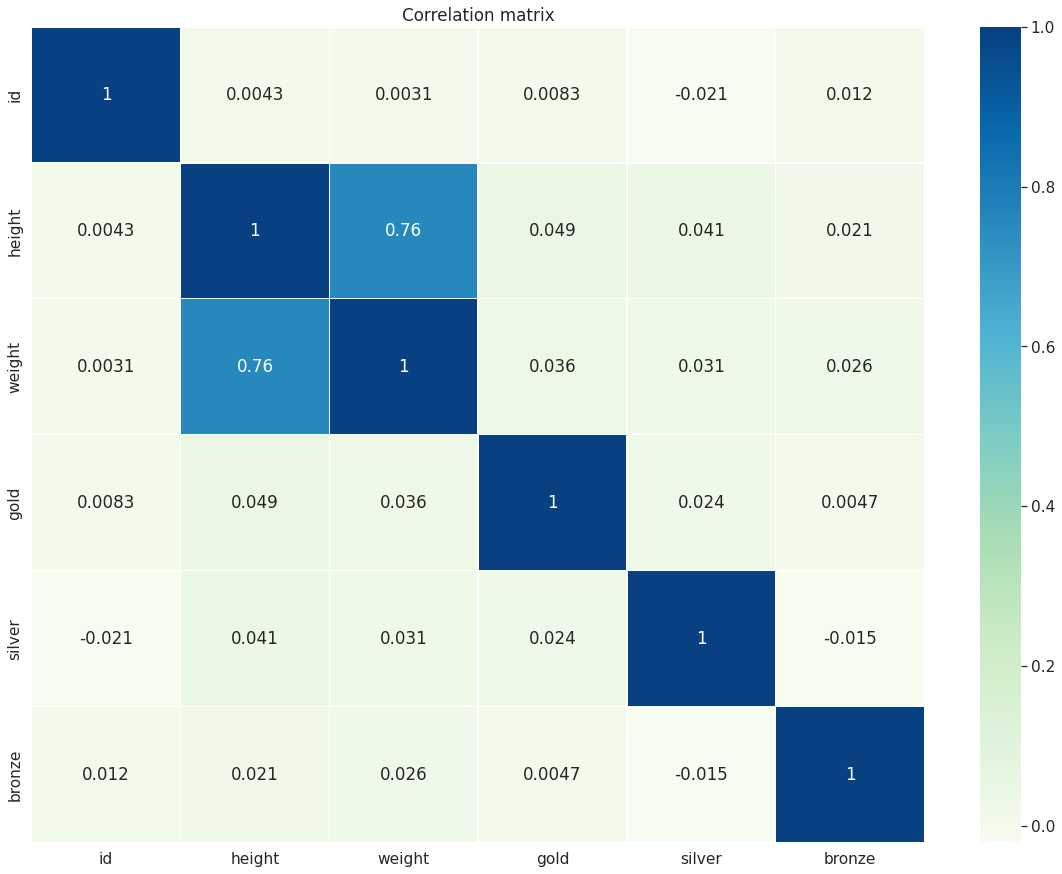

In [ ]:
plt.figure(figsize=(20,15))

sns.set(font_scale=1.4)
sns.heatmap(data.drop(columns=TARGET_NAME).corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Устранение выбросов

In [ ]:
data.describe()

,id,height,weight,gold,silver,bronze
count,1.153800e+04,11208.000000,10879.000000,11538.000000,11538.000000,11538.000000
mean,4.999885e+08,1.766282,72.068205,0.057722,0.056769,0.061016
std,2.908648e+08,0.112719,16.177334,0.255910,0.239147,0.243320
min,1.834700e+04,1.210000,31.000000,0.000000,0.000000,0.000000
25%,2.450997e+08,1.690000,60.000000,0.000000,0.000000,0.000000
50%,5.002011e+08,1.760000,70.000000,0.000000,0.000000,0.000000
75%,7.539874e+08,1.840000,81.000000,0.000000,0.000000,0.000000
max,9.999878e+08,2.210000,170.000000,5.000000,2.000000,2.000000


In [ ]:
data.weight.nlargest(10)

1387    170.0
2337    170.0
4453    165.0
3393    163.0
2425    160.0
8839    160.0
8623    159.0
5981    157.0
7117    157.0
2346    155.0
Name: weight, dtype: float64

In [ ]:
data.nsmallest(10, 'weight')

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
3429,777180519,Flavia Saraiva,BRA,female,9/30/99,1.33,31.0,gymnastics,0,0,0
11124,44353519,Yan Wang,CHN,female,10/30/99,1.40,33.0,gymnastics,0,0,1
2106,74882200,Chunsong Shang,CHN,female,3/18/96,1.43,34.0,gymnastics,0,0,1
9346,49083611,Sae Miyakawa,JPN,female,9/10/99,1.45,34.0,gymnastics,0,0,0
210,676958658,Aiko Sugihara,JPN,female,9/19/99,1.46,35.0,gymnastics,0,0,0
9630,471386171,Seda Tutkhalian,RUS,female,7/15/99,1.42,35.0,gymnastics,0,1,0
11230,923838612,Yi Mao,CHN,female,9/16/99,1.51,35.0,gymnastics,0,0,1
4890,497442355,Jiaxin Tan,CHN,female,12/3/96,1.48,36.0,gymnastics,0,0,1
1221,137582033,Asuka Teramoto,JPN,female,11/19/95,1.45,37.0,gymnastics,0,0,0
8339,500712109,Oreane Lechenault,FRA,female,8/31/00,1.34,37.0,gymnastics,0,0,0


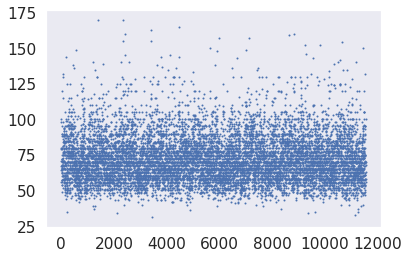

In [ ]:
plt.scatter(data.index, data['weight'], s=1)
plt.grid()

Выводим распределение по весу

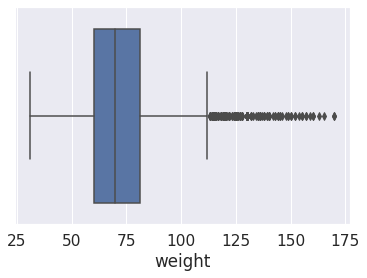

In [ ]:
get_boxplot(data, columns=['weight'])
# q1 - 1.5 * IQR
# q3 + 1.5 * IQR

Выводим распределение по росту

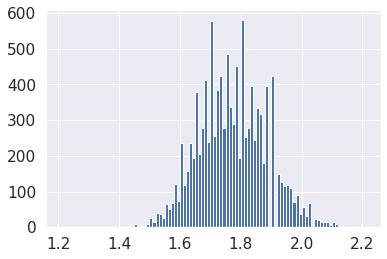

In [ ]:
data['height'].hist(bins=100)
plt.show()

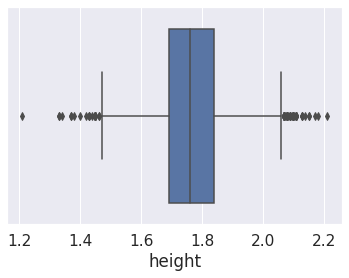

In [ ]:
get_boxplot(data, columns=['height'])

## Вывод:  
без возраста сложно определить вес, но судя по высоте с весом все нормально и это не отклонения от нормы

Устранение пропусков

In [ ]:
round((len(data) - data.count()) / len(data) * 100, 2).sort_values(ascending=False).head()

weight    5.71
height    2.86
dob       0.01
id        0.00
name      0.00
dtype: float64

выводим значения с пропусками

In [ ]:
data.isnull().sum()

id               0
name             0
nationality      0
sex              0
dob              1
height         330
weight         659
sport            0
gold             0
silver           0
bronze           0
dtype: int64

In [ ]:
data.loc[data['weight'].isna(), :].head(10).style.highlight_null(null_color='#EA4335')

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
12,258556239,Abbas Qali,IOA,male,10/11/92,nan,nan,aquatics,0,0,0
28,349871091,Abdelhafid Benchabla,ALG,male,9/26/86,1.860000,nan,boxing,0,0,0
30,23564778,Abdelkader Chadi,ALG,male,12/12/86,1.780000,nan,boxing,0,0,0
37,934545704,Abdelrahman Salah Orabi Abdelgawwad,EGY,male,10/9/87,1.850000,nan,boxing,0,0,0
47,469953606,Abdoullah Bamoussa,ITA,male,6/8/86,nan,nan,athletics,0,0,0
50,325809293,Abdul Omar,GHA,male,10/3/93,nan,nan,boxing,0,0,0
52,262868423,Abdulaziz Alshatti,IOA,male,10/30/90,nan,nan,fencing,0,0,0
53,101781750,Abdulkadir Abdullayev,AZE,male,7/17/88,1.880000,nan,boxing,0,0,0
56,897549624,Abdullah Hel Baki,BAN,male,8/1/89,nan,nan,shooting,0,0,0
57,153457,Abdullahi Shehu,NGR,male,3/12/93,1.700000,nan,football,0,0,1


вес без роста будут плохими помощниками  
можно было привести к средним значениям, но это искажение данных

In [ ]:
data.loc[(data['height'].isna()) & (data['weight'].isnull()), :].head(10)

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
12,258556239,Abbas Qali,IOA,male,10/11/92,NaN,NaN,aquatics,0,0,0
47,469953606,Abdoullah Bamoussa,ITA,male,6/8/86,NaN,NaN,athletics,0,0,0
50,325809293,Abdul Omar,GHA,male,10/3/93,NaN,NaN,boxing,0,0,0
52,262868423,Abdulaziz Alshatti,IOA,male,10/30/90,NaN,NaN,fencing,0,0,0
56,897549624,Abdullah Hel Baki,BAN,male,8/1/89,NaN,NaN,shooting,0,0,0
59,937153550,Abdulrahman Al Faihan,IOA,male,6/24/86,NaN,NaN,shooting,0,0,0
62,884912875,Abeku Gyekye Jackson,GHA,male,4/12/00,NaN,NaN,aquatics,0,0,0
94,222063859,Adama Jammeh,GAM,male,6/10/93,NaN,NaN,athletics,0,0,0
139,577601340,Afa Ismail,MDV,female,11/1/93,NaN,NaN,athletics,0,0,0
165,443237540,Ahmad Alafasi,IOA,male,1/10/83,NaN,NaN,shooting,0,0,0


Кол-во строк пропусков роста с весом

In [ ]:
data.loc[(data['height'].isna()) & (data['weight'].isnull()), 'id'].count()

309

Убираем значения где NaN  в колонках height и weight

In [ ]:
data = data.loc[~((data['height'].isna()) & (data['weight'].isnull())), :]

In [ ]:
data.isnull().sum()

id               0
name             0
nationality      0
sex              0
dob              0
height          21
weight         350
sport            0
gold             0
silver           0
bronze           0
dtype: int64

Смотрим уникальные значения

In [ ]:
np.unique(data['weight'], return_counts=True)

(array([ 31.,  33.,  34.,  35.,  36.,  37.,  39.,  40.,  41.,  42.,  43.,
         44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
         55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
         66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
         77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
         88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
         99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
        110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
        121., 122., 123., 124., 125., 126., 127., 128., 130., 132., 133.,
        134., 135., 136., 137., 138., 139., 140., 142., 143., 144., 145.,
        146., 148., 149., 150., 152., 154., 155., 157., 159., 160., 163.,
        165., 170.,  nan]),
 array([  1,   1,   2,   3,   1,   3,   5,   7,   3,  12,  22,  18,  44,
         41,  59, 125,  65, 157,  96, 161, 168, 174, 238, 214, 257, 336,
        220,

In [ ]:
data.loc[data['weight'].isnull(), :]

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
28,349871091,Abdelhafid Benchabla,ALG,male,9/26/86,1.86,NaN,boxing,0,0,0
30,23564778,Abdelkader Chadi,ALG,male,12/12/86,1.78,NaN,boxing,0,0,0
37,934545704,Abdelrahman Salah Orabi Abdelgawwad,EGY,male,10/9/87,1.85,NaN,boxing,0,0,0
53,101781750,Abdulkadir Abdullayev,AZE,male,7/17/88,1.88,NaN,boxing,0,0,0
57,153457,Abdullahi Shehu,NGR,male,3/12/93,1.70,NaN,football,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
11465,980866226,Zhaina Shekerbekova,KAZ,female,12/17/89,1.54,NaN,boxing,0,0,0
11468,405483135,Zhanibek Alimkhanuly,KAZ,male,4/1/93,1.82,NaN,boxing,0,0,0
11513,352983859,Zohir Kedache,ALG,male,3/2/86,1.78,NaN,boxing,0,0,0
11514,424586991,Zohra Ez Zahraoui,MAR,female,11/18/83,1.65,NaN,boxing,0,0,0


In [ ]:
data.loc[data.index == 28, :]

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
28,349871091,Abdelhafid Benchabla,ALG,male,9/26/86,1.86,NaN,boxing,0,0,0


Задаем среднее в наборе измерений веса для роста

In [ ]:
weight_median = round(data.groupby(['height'])['weight'].agg(['median'])).reset_index()
weight_nan = data.loc[data['weight'].isna(), 'height'].drop_duplicates()

for i in data.loc[data['weight'].isna(), 'height'].drop_duplicates():
  for j in weight_median['height']:
    if i == j:
      data.loc[(data['height'] == i) & (data['weight'].isna()), 'weight'] = weight_median.loc[weight_median['height'] == j, 'median'].item()

Проверяем по индексу ячейку с ростом

In [ ]:
data.loc[data.index == 28, :]

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
28,349871091,Abdelhafid Benchabla,ALG,male,9/26/86,1.86,80.0,boxing,0,0,0


Сравниваем значение со средним в наборе

In [ ]:
weight_median.loc[weight_median['height'] == 1.86,:]

,height,median
50,1.86,80.0


Проверяем что другие с ростом 1.86 не изменили

In [ ]:
data.loc[data['height'] == 1.86,:].head()

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
28,349871091,Abdelhafid Benchabla,ALG,male,9/26/86,1.86,80.0,boxing,0,0,0
29,904808208,Abdelhakim Amokrane,ALG,male,5/10/94,1.86,70.0,football,0,0,0
61,841446548,Abdulrazzaq Murad,QAT,male,6/29/90,1.86,77.0,handball,0,0,0
101,325622113,Adelina Bogus,ROU,female,9/4/88,1.86,75.0,rowing,0,0,1
117,284555275,Adrian Crisan,ROU,male,5/7/80,1.86,85.0,table tennis,0,0,0


In [ ]:
del weight_median
data.isnull().sum()

id              0
name            0
nationality     0
sex             0
dob             0
height         21
weight          0
sport           0
gold            0
silver          0
bronze          0
dtype: int64

## переводим категориальные в количественные

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [ ]:
data[['name', 'nationality', 'sex', 'dob', 'sport']] = data.select_dtypes(include='object').apply(le.fit_transform)

In [ ]:
data[['name', 'nationality', 'sex', 'dob', 'sport']].head()

,name,nationality,sex,dob,sport
0,0,59,1,616,2
1,1,101,0,5305,9
2,2,33,1,3476,2
3,3,117,1,192,22
4,4,138,1,1209,7


In [ ]:
data.dtypes

id               int64
name             int64
nationality      int64
sex              int64
dob              int64
height         float64
weight         float64
sport            int64
gold             int64
silver           int64
bronze           int64
dtype: object

# С помощью линейной регрессии предсказываем значения для пропусков

In [ ]:
features_for_lr = ['name', 'nationality', 'sex', 'dob','weight', 'sport', 'gold','silver','bronze']

In [ ]:
df_height = data[data['height'].notnull()]

In [ ]:
scaler = StandardScaler()

X_h = scaler.fit_transform(df_height[features_for_lr])
y_h = df_height['height']

model_lr_h = LinearRegression()
model_lr_h.fit(X_h, y_h)

LinearRegression()

Смотрим влияние колонок на предсказание

In [ ]:
pd.DataFrame(zip(model_lr_h.coef_, features_for_lr), columns=['coef', 'feature_name']).sort_values(by='coef', ascending=False)

,coef,feature_name
4,0.076473,weight
2,0.020214,sex
6,0.002985,gold
7,0.002588,silver
8,0.001223,bronze
3,0.000640,dob
1,0.000275,nationality
0,-0.001291,name
5,-0.011455,sport


Записываем вместо NaN предсказанные значения

In [ ]:
data.loc[data['height'].isnull(), 'height'] = model_lr_h.predict(scaler.transform(data.loc[data['height'].isnull(), features_for_lr])).round(2)

In [ ]:
data.notnull().sum()

id             11229
name           11229
nationality    11229
sex            11229
dob            11229
height         11229
weight         11229
sport          11229
gold           11229
silver         11229
bronze         11229
dtype: int64

## Определяем результат фичей в паре, которые сильнее влияют на целевую переменную

In [ ]:
main_features(data).shape

(29, 3)

In [ ]:
main_features(data).head(5)

,first_feature,second_feature,impact on Y in %
0,nationality,sport,17.30
1,dob,weight,12.23
2,height,gold,9.46
3,name,weight,7.64
4,0.0,dob,6.70


# Нормализация данных

In [ ]:
data = data.drop("id", axis=1)

In [ ]:
scaler = StandardScaler()

features_for_sc = ['name', 'nationality','dob', 'height', 'weight', 'sport', 'gold','silver','bronze']
data[features_for_sc] = scaler.fit_transform(data[features_for_sc])

In [ ]:
data.head()

,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,-1.731822,-0.581058,1,-1.361164,-0.410608,-0.495639,-0.961003,-0.228179,-0.23995,-0.253031
1,-1.731513,0.136614,0,1.589621,-0.765497,-0.994336,-0.137282,-0.228179,-0.23995,-0.253031
2,-1.731204,-1.025332,1,0.438632,1.896170,0.439419,-0.961003,-0.228179,-0.23995,3.823417
3,-1.730895,0.410013,1,-1.627987,0.565336,0.501756,1.392487,-0.228179,-0.23995,-0.253031
4,-1.730586,0.768850,1,-0.987989,0.387892,-0.059278,-0.372631,-0.228179,-0.23995,-0.253031


## Разбиение на train и test

In [ ]:
X = data.drop(columns=TARGET_NAME)
y = data[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=42)

DecisionTreeClassifier,LogisticRegression показало хуже результат поэтому взял CatBoostClassifier

In [ ]:
model_catb = catb.CatBoostClassifier(class_weights=[0.7, 1.8], silent=True, random_state=42)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.97      0.75      0.84      4069
           1       0.82      0.98      0.89      4914

    accuracy                           0.87      8983
   macro avg       0.90      0.86      0.87      8983
weighted avg       0.89      0.87      0.87      8983

TEST

              precision    recall  f1-score   support

           0       0.92      0.65      0.76      1007
           1       0.77      0.95      0.85      1239

    accuracy                           0.82      2246
   macro avg       0.85      0.80      0.81      2246
weighted avg       0.84      0.82      0.81      2246

CONFUSION MATRIX

col_0    0     1
sex             
0      655   352
1       56  1183


## Подбор гиперпараметров

In [ ]:
model_catb = catb.CatBoostClassifier(max_depth=4,
                                     class_weights=[0.7, 1.8], silent=True, random_state=42)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)
y_test_pred_probs = model_catb.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.94      0.67      0.78      4069
           1       0.78      0.97      0.86      4914

    accuracy                           0.83      8983
   macro avg       0.86      0.82      0.82      8983
weighted avg       0.85      0.83      0.83      8983

TEST

              precision    recall  f1-score   support

           0       0.93      0.62      0.75      1007
           1       0.76      0.96      0.85      1239

    accuracy                           0.81      2246
   macro avg       0.85      0.79      0.80      2246
weighted avg       0.84      0.81      0.80      2246

CONFUSION MATRIX

col_0    0     1
sex             
0      626   381
1       45  1194


## Важность признаков

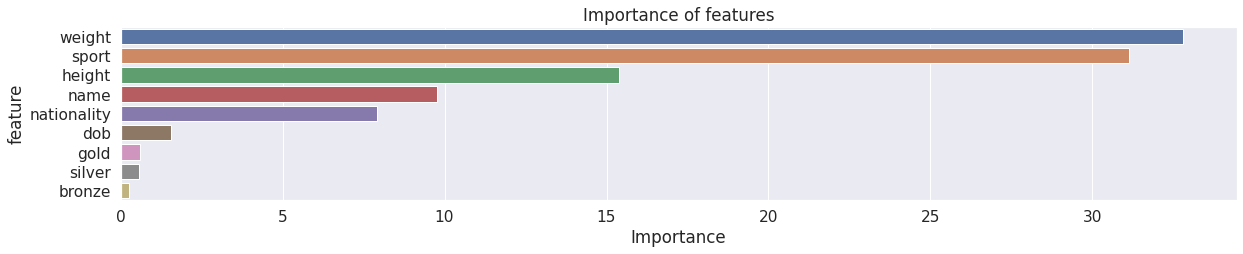

In [ ]:
show_feature_importances(X.columns, model_catb.feature_importances_)

## Выбор порога вероятности для определения класса

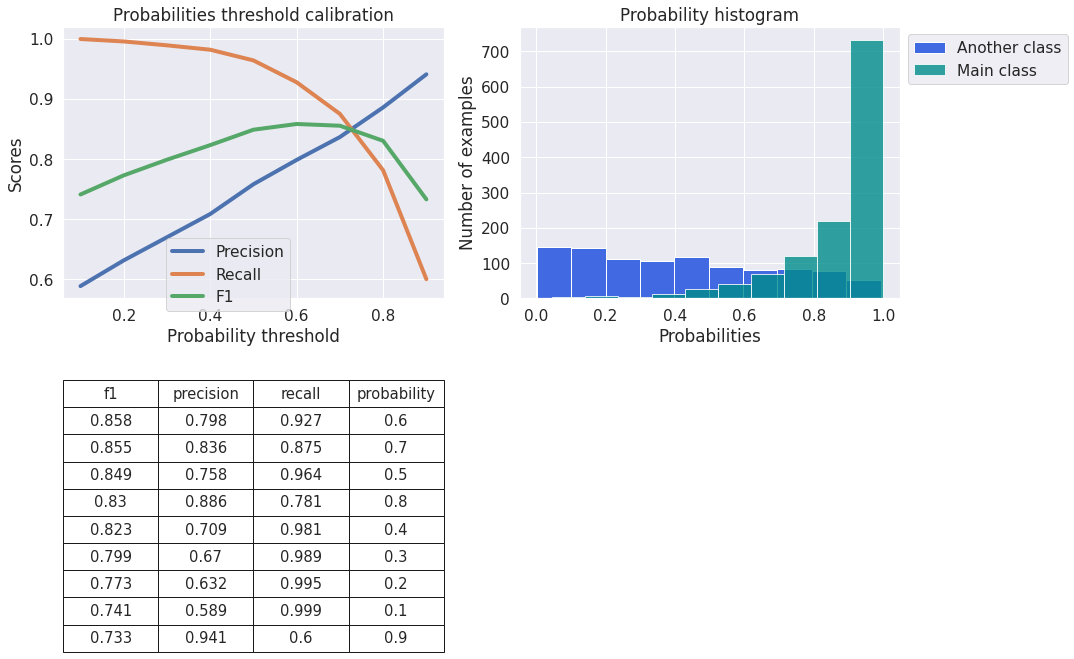

In [ ]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

## Обучение финальной модели и оценка результатов

In [ ]:
final_model = catb.CatBoostClassifier(max_depth=4,
                                      class_weights=[0.7, 1.8], silent=True, random_state=42)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
y_pred_probs = final_model.predict_proba(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.62      0.75      1007
           1       0.76      0.96      0.85      1239

    accuracy                           0.81      2246
   macro avg       0.85      0.79      0.80      2246
weighted avg       0.84      0.81      0.80      2246



In [ ]:
# выстявляем границу пересечения метрик
prob_threshold = 0.74

print(classification_report(y_test, (y_pred_probs[:, 1] > prob_threshold).astype(int)))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1007
           1       0.85      0.83      0.84      1239

    accuracy                           0.83      2246
   macro avg       0.83      0.83      0.83      2246
weighted avg       0.83      0.83      0.83      2246



<font color="blue"> Вывод: Нашли порог вероятности для классов. Увеличили f1-score </font>

## Постройте ROC-кривую с помощью функции sklearn.metrics. roc_curve.

In [ ]:
# посчитаем ROC-кривую (Receiver Operating Characteristic)
from sklearn.metrics import roc_curve
# calculate the fpr and tpr for all thresholds of the classification
probs = final_model.predict_proba(X_test)
preds = probs[:,1]
# получаем значения false и true positive rate для различных значений порога
fpr, tpr, threshold = metrics.roc_curve(y_test, preds )
roc_auc = metrics.auc(fpr, tpr)

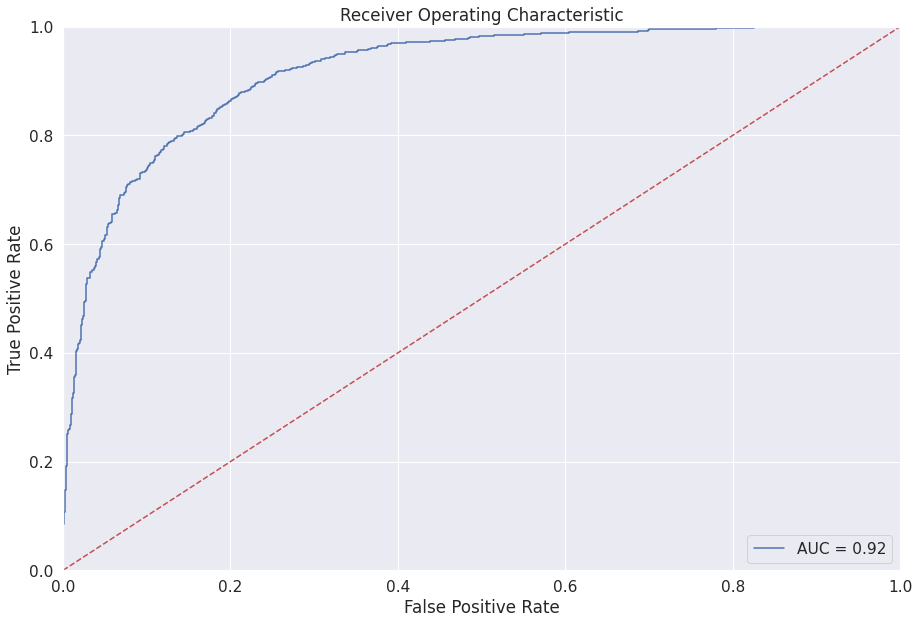

In [ ]:
plt.figure(figsize = (15, 10))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Вычислите значение ROC-AUC метрики с помощью функции sklearn.metrics.roc_auc_score.

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, final_model.predict_proba(X_test)[:, 1])

0.9177092074606086

## Реализуйте подсчет метрик TPR, FPR «вручную», без использования готовых функций из библиотеки sklearn.

Площадь, рассчитанная ручным способом:  0.9177092074606086


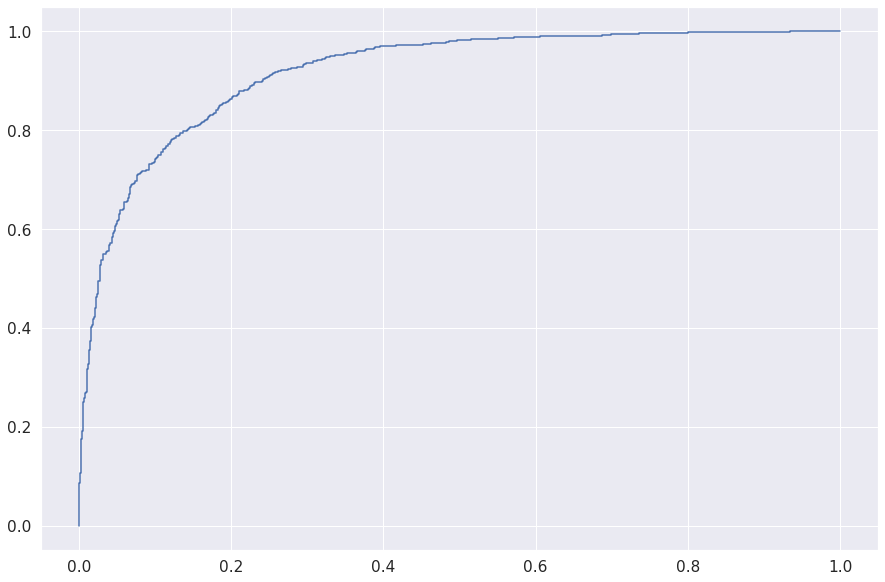

In [ ]:
def roc_curve_1(probabilities, y_test, thresholds):

    # Initialize FPR & TPR arrays
    tpr = []
    fpr = []  

    # Compute FPR & TPR
    for t in range(0, len(thresholds)):
        y_pred = np.where(probabilities >= thresholds[t], 1, 0)
        fp = np.sum((y_pred == 1) & (y_test == 0))
        tp = np.sum((y_pred == 1) & (y_test == 1))
        fn = np.sum((y_pred == 0) & (y_test == 1))
        tn = np.sum((y_pred == 0) & (y_test == 0))
        tpr.append(tp/(tp+fn))
        fpr.append(fp/(fp+tn))

    return fpr, tpr

fpr_1, tpr_1 = roc_curve_1(preds, y_test, threshold)

print('Площадь, рассчитанная ручным способом: ', metrics.auc(fpr, tpr))
plt.figure(figsize = (15, 10))
plt.plot(fpr, tpr);

## Постройте ROC-кривую с помощью вычисленных в п. 5 метрик: объедините графики из п. 3 и п. 6 в один. Сравните, сделайте вывод.

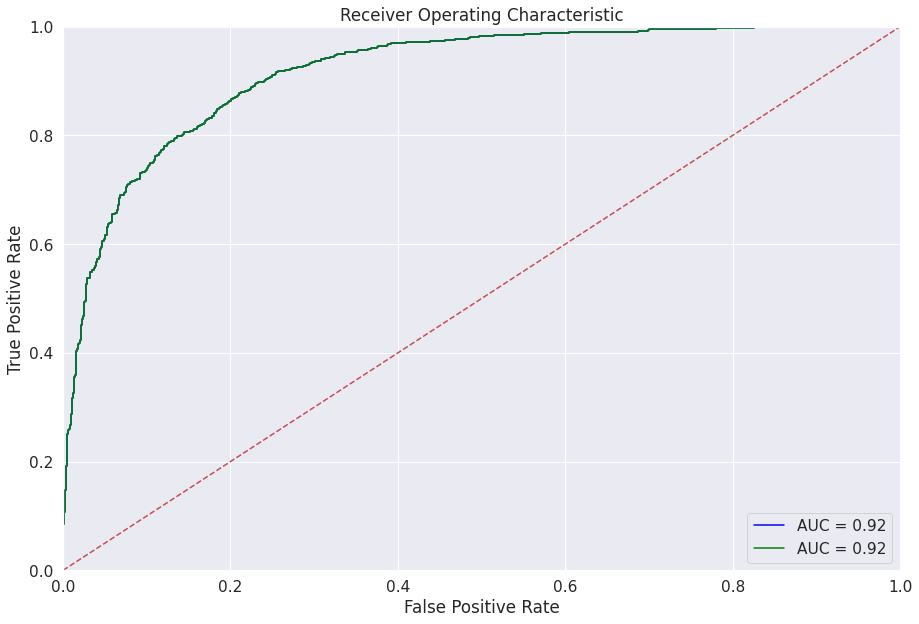

In [ ]:
plt.figure(figsize = (15, 10))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc,color='blue')
plt.plot(fpr_1, tpr_1, 'b', label = 'AUC = %0.2f' % roc_auc,color='green')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Вывод: данные совпадают.

## Постройте график Precision-Recall, используя метрики

In [ ]:
tp = 0 # True positive
fp = 0 # False positive
fn = 0 # False negative
tn = 0 # True negative

predictions = final_model.predict_proba( X_test )
for predicted_prob, actual in zip( predictions[:, 1], y_test ):    
    if predicted_prob >= 0.74:
        predicted = 1
    else:
        predicted = 0
    
    if predicted == 1:
        if actual == 1:
            tp += 1
        else:
            fp += 1
    
    else:
        if actual == 1:
            fn += 1
        else:
            tn += 1

In [ ]:
precision = tp / (tp + fp)
precision

0.8523102310231023

In [ ]:
recall = tp / (tp + fn)
recall

0.8337368845843423